# Tutorial 1: SpaCon for mouse 3D spatial transcriptome and structural connectivity

This tutorial demonstrates how to integrate whole‑brain mouse spatial transcriptomics data with structural connectivity data using SpaCon. The spatial transcriptomics data are MERFISH datasets provided by Zhang et al. (2023) (available at https://www.nature.com/articles/s41586-023-06808-9), and the structural connectivity data are from the Allen Mouse Brain Connectivity Atlas (https://connectivity.brain‑map.org/). Both datasets have been registered to the same resolution; the processed data can be downloaded from XXXXX.

Note: To use your own data, first ensure that the spatial transcriptomics and connectivity datasets are matched one‑to‑one (the transcriptomics data should be a spot × gene matrix and the connectivity data a spot × spot matrix).

In [1]:
import sys
sys.path.append("/mnt/Data16Tc/home/haichao/code/SpaCon_github/SpaCon/SpaCon/")
from scipy.sparse import coo_matrix, save_npz, load_npz
from model.utils import build_spatial_graph, build_connection_graph, neighbor_sample, model_train, model_eval, clustering

from model.Model_Pyg_SpaCon import SpaCon
# from model.r_mcluster import mclust_R

import torch.nn.functional as F
import copy
import datetime
import os
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

import torch
import numpy as np
from tqdm import tqdm
import pickle
import random

import warnings
warnings.filterwarnings("ignore")

mus = 'mouse_1'
if mus == 'mouse_1':  # coronal
    plot_x, plot_y = 'z', 'y'
    figsize = (5,5)
elif mus == 'mouse_3':   # sagittal
    plot_x, plot_y = 'x', 'y'
    figsize = (11,5)


cluster_color=['#537eb7','#83ab8e','#ece399','#405993','#cc7f73',
             
             '#d69971','#df5734','#6c408e','#9a70a8','#d4c2db',
             '#53738c','#a25087','#a78982','#a9c2cb','#92699e',
             '#4b6aa8','#3ca0cf','#c376a7','#ad98c3','#408444',
             '#b95055','#d5bb72','#bc9a7f','#e0cfda','#d8a0c0',
             '#e6b884','#b05545','#d69a55','#64a776','#cbdaa9',
             '#efd2c9','#da6f6d','#ebb1a4','#a44e89','#8c564b',
             '#b85292','#6d6fa0','#8d689d','#c8c7e1','#d25774',
             '#c49abc','#a5a9b0','#927c9a','#9f8d89','#72567a',
             '#63a3b8','#c4daec','#61bada','#b7deea','#e29eaf',
             '#4490c4','#e6e2a3','#de8b36','#c4612f','#ad98c3',
             '#76a2be','#cea5c7','#c6adb0','#9d3b62','#2d3462', "#FF420E", "#FFBB00"]

def set_seed(seed: int):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

### Data preprocessing 

load spatial transcriptomics data

In [2]:
adata = sc.read_h5ad(f'./data/{mus}/adata_merge.h5ad')
print('raw adata shape:', adata.shape)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata

raw adata shape: (250535, 1122)


AnnData object with n_obs × n_vars = 250535 × 1122
    obs: 'x_section_mean', 'x', 'y', 'z', 'section', 'NT_index', 'Cells_id'
    uns: 'log1p'

build spatial graph

In [3]:
# build the section list
section_order = np.unique(adata.obs['section']).tolist()
# calculate the spatial graph for the adata
ST_graph_data, st_adj = build_spatial_graph(adata=adata,  rad_cutoff=0.7, rad_cutoff_Zaxis=1.0,
                                            sec_x='z', sec_y='y', key_section='section',
                                            section_order=section_order)
ST_graph_data

100%|██████████| 128/128 [01:24<00:00,  1.51it/s]


Data(x=[250535, 1122], edge_index=[2, 1681795])

load connectivity data and build connection graph

In [4]:
eps = 0.001
proportion_after = 0.0211
with open(f'/mnt/Data18Td/Data/haichao/mouse_connect_data/NT/zxw/{mus}/PyG_Data_eps{eps}_{proportion_after}.pkl', 'rb') as f:
    NT_graph_data = pickle.load(f)

with open(f'/mnt/Data18Td/Data/haichao/mouse_connect_data/ST/zxw/{mus}/PyG_Data_xy0.7_z1.0.pkl', 'rb') as f:
    ST_graph_data = pickle.load(f)
st_adj = load_npz(f'/mnt/Data18Td/Data/haichao/mouse_connect_data/ST/zxw/{mus}/zxw_adj.npz')
# nt_adj = np.load('/mnt/Data18Td/Data/haichao/mouse_connect_data/NT/zxw/mouse_1/zxw_adj.npy')
# NT_graph_data = build_connection_graph(adata, nt_adj, threshold=0.001)
NT_graph_data

Data(x=[250535, 1122], edge_index=[2, 1324207857])

In [4]:
train_loader, evaluate_loader_con, evaluate_loader_spa = neighbor_sample(NT_graph_data, ST_graph_data, batch_size=64, train_num_neighbors=[20, 10, 10], num_workers=4)

In [5]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# hyper-parameters
num_epoch = 4
lr = 0.0001
weight_decay = 1e-4
hidden_dims = [adata.X.shape[1]] + [256, 64, 16]    
# model
model = SpaCon(hidden_dims=hidden_dims, fusion_method='add').to(device)
# if model_save_path=None, the model will not be saved
results_save_path = f"./results/{mus}/{str(datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S'))}/"
os.makedirs(results_save_path, exist_ok=True)

model = model_train(num_epoch, lr, weight_decay, model, train_loader, st_adj, model_save_path=results_save_path, device=device)

epoch:1|4


100%|██████████| 3915/3915 [06:04<00:00, 10.73it/s]


epoch:2|4


100%|██████████| 3915/3915 [06:20<00:00, 10.29it/s]


epoch:3|4


100%|██████████| 3915/3915 [06:07<00:00, 10.65it/s]


epoch:4|4


100%|██████████| 3915/3915 [06:20<00:00, 10.30it/s]

Training completed! The model parameters have been saved to ./results/mouse_1/2025_07_11_15_02_06//model_params.pth


In [6]:

adata = model_eval(model, adata, NT_graph_data, ST_graph_data, evaluate_loader_con, evaluate_loader_spa, st_adj, layer_eval=True, device=device)

Evaluating: 100%|██████████| 751605/751605 [01:05<00:00, 11541.67it/s]

The results have been saved in adata.obsm
AnnData object with n_obs × n_vars = 250535 × 1122
    obs: 'x_section_mean', 'x', 'y', 'z', 'section', 'NT_index', 'Cells_id'
    uns: 'log1p'
    obsm: 'feature_spa', 'feature_con'


In [6]:
adata = sc.read_h5ad('/mnt/Data16Tc/home/haichao/code/SpaCon/ST_NT_cluster/SpaCon_apply_zxw/results/mouse_1/2024_04_08_20_10_00GATE_2encoder_cat_feature_decoder_skip_connect_bn/feature_add_weight1/Clusters_res0.75/adata_cluster_feature.h5ad')


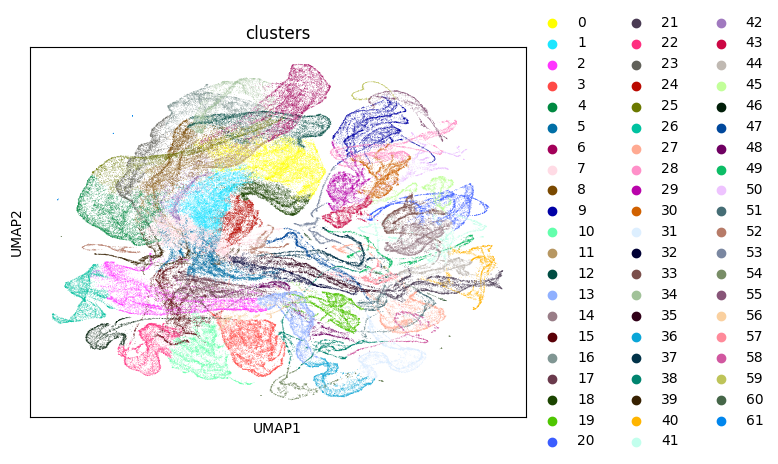

In [7]:
# adata = clustering(adata, alpha=1, adata_save_path=results_save_path, cluster_resolution=0.75, 
#                           plot_all_cluster_results=False, figsize=figsize, plot_x=plot_x, plot_y=plot_y)
sc.pl.umap(adata,color='clusters', show=True)


[<Axes: title={'center': 'clusters'}, xlabel='spatial1', ylabel='spatial2'>]

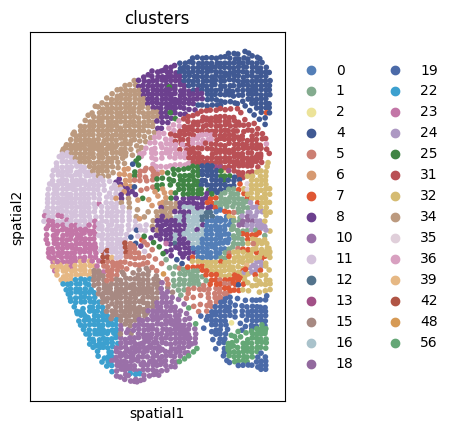

In [8]:
# 2D result plot

adata.obsm['spatial'] = adata.obs[['z', 'y']].values
adata_s = adata[adata.obs['section'] == 'Zhuang-ABCA-1.081']
adata_s = adata_s[adata_s.obs['z'] < 56]   # Removal of part of the right brain
sc.pl.spatial(adata_s, color='clusters', spot_size=1.25, show=False, palette=cluster_color)

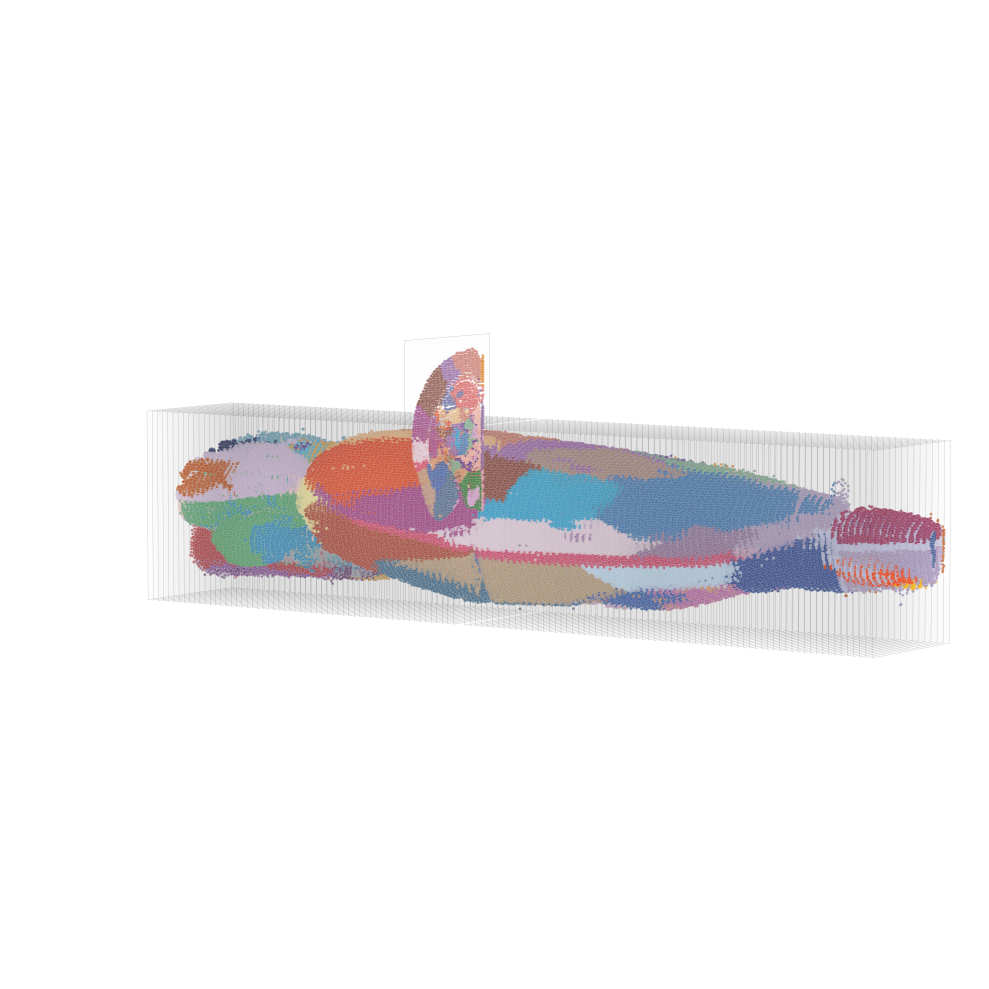

In [22]:
# 3D result plot

from model.utils import result_plot_3D

result_plot_3D(adata, highlight_section='Zhuang-ABCA-1.081', cluster_color=cluster_color)

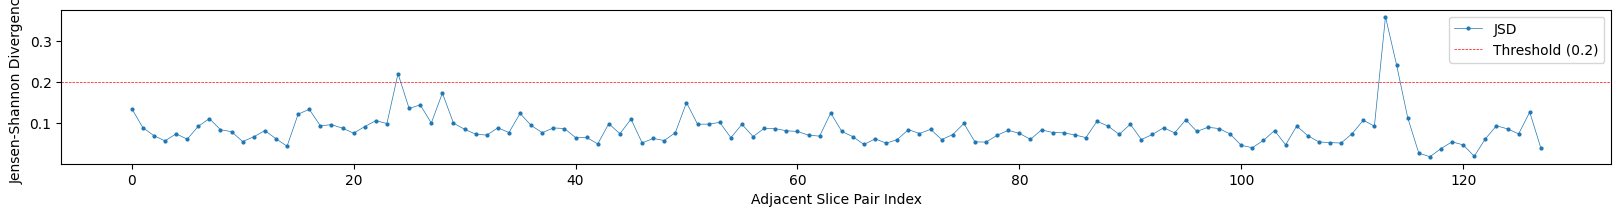

In [23]:
sec_cluster_df = pd.DataFrame(0, index=[str(i) for i in range(len(adata.obs['clusters'].unique()))], columns=sorted(adata.obs['section'].unique()))
for sec in sorted(adata.obs['section'].unique()):
    adata_s = adata[adata.obs['section'] == sec]
    cluster_counts = adata_s.obs['clusters'].value_counts()
    for cluster, count in cluster_counts.items():
        sec_cluster_df.loc[cluster, sec] = count


sec_cluster_df_proportions = sec_cluster_df.div(sec_cluster_df.sum(axis=0), axis=1)
sec_cluster_df_proportions = sec_cluster_df_proportions.iloc[:, ::-1]
sec_cluster_df_proportions = sec_cluster_df_proportions.dropna()


from scipy.spatial.distance import jensenshannon

jsd_diff = []
for i in range(len(sec_cluster_df_proportions.columns) - 1):
    slice1 = sec_cluster_df_proportions.columns[i]
    slice2 = sec_cluster_df_proportions.columns[i+1]
    
    p = sec_cluster_df_proportions.iloc[:, i].values.astype(float)
    q = sec_cluster_df_proportions.iloc[:, i+1].values.astype(float)
    jsd = jensenshannon(p, q)
    jsd_diff.append(jsd)

plt.figure(figsize=(20,2))
line, = plt.plot(jsd_diff, marker='o', linestyle='-', label='JSD', lw=0.5, ms=2)

plt.axhline(0.2, color='red', linestyle='--', label='Threshold (0.2)', lw=0.5)
plt.xlabel('Adjacent Slice Pair Index')
plt.ylabel('Jensen-Shannon Divergence')
plt.legend()